# WZE-UAV Image Classification using Deep Learning

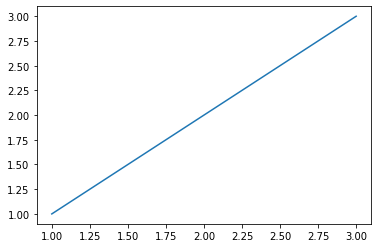

In [1]:
import os
import glob
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import mlxtend
from pathlib import Path
from tqdm.auto import tqdm

x = (1,3)
y = (1,3)
plt.plot(x,y)

In [2]:
import torch
import torchvision.transforms as T
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchinfo import summary
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torchinfo import summary
import h5py

In [3]:
import wze_uav.data_loader as data_loader

#### Get PyTorch version

In [4]:
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.1+cu116
torchvision version: 0.14.1+cu116


#### Preparing device agnostic code 

In [91]:
# ensure device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# get index of currently selected device
print(f"Index of current divice: {torch.cuda.current_device()}")
# get number of GPUs available
print(f"Number of GPUs available: {torch.cuda.device_count()}")
# get the name of the device
print(f"GPU Model: {torch.cuda.get_device_name(0)}")

cuda
Index of current divice: 0
Number of GPUs available: 1
GPU Model: Quadro RTX 8000


#### Ensure reproducibility 

In [6]:
# for more information, see also: https://pytorch.org/docs/stable/notes/randomness.html

# Set seeds
def set_seeds(seed: int=0):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

# seed for numpy
np.random.seed(0)
# avoiding non-deterministic algorithms
#torch.use_deterministic_algorithms(True)
# Set to true -> might speed up the process but should be set to False if reproducible results are desired
torch.backends.cudnn.benchmark = True


#### Define file directories

In [85]:
set_seeds() # ensure reproducibility

train_data_path = r"D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\2020\ROI\rgb\train"
val_data_path = r"D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\2020\ROI\rgb\val"
test_data_path = r"D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\2020\ROI\rgb\test"



In [86]:
# load all image and feature arrays from hdf5

train_image_set, train_label_set, train_species_set = data_loader.hdf5_to_img_label(train_data_path, load_sets = ["images_masked"])
val_image_set, val_label_set, val_species_set = data_loader.hdf5_to_img_label(val_data_path, load_sets = ["images_masked"])
test_image_set, test_label_set, test_species_set = data_loader.hdf5_to_img_label(test_data_path, load_sets = ["images_masked"])

In [12]:
print(test_image_set.shape)
print(test_label_set.shape)

(758, 250, 250, 3)
(758, 1)


In [88]:
transform = transforms.Compose([transforms.ToTensor(),
                                #transforms.Resize(64)
                               ])

class_idx = {'healthy':[0, 1],'stressed':[2, 3], 'dead':[4]}
class_names = ['healthy', 'stressed', 'dead']

train_dataset = data_loader.CustomDataset(
    data = train_image_set,
    labels = train_label_set,
    class_names=class_names,
    class_idx=class_idx, 
    species = train_species_set,
    transform=transform)

val_dataset = data_loader.CustomDataset(
    data = val_image_set,
    labels = val_label_set,
    class_names=class_names,
    class_idx=class_idx, 
    species = val_species_set,
    transform=transform)

test_dataset = data_loader.CustomDataset(
    data = test_image_set,
    labels = test_label_set,
    class_names=class_names,
    class_idx=class_idx, 
    species = test_species_set,
    transform=transform)



In [89]:
print(len(train_dataset), len(val_dataset), len(test_dataset))
print(test_dataset[0][0].shape)
print(test_dataset[0][1].shape)
test_dataset.species[0]

5427 678 758
torch.Size([3, 250, 250])
torch.Size([1])


tensor([134], dtype=torch.int32)

In [82]:
# 1. Take in a Dataset as well as a list of class names
from typing import Dict, List, Tuple
import random

def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[int] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(30, 20))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label, targ_species = dataset[targ_sample][0], dataset[targ_sample][1], dataset.species[targ_sample]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(2, 1, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]} | {targ_label}"
            if display_shape:
                title = title + f"\nshape: {targ_species}"
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

#print(test_image_set[0,:,:,:].dtype)
#print(test_dataset[0][0].dtype)
#print(test_dataset[0][1].dtype)

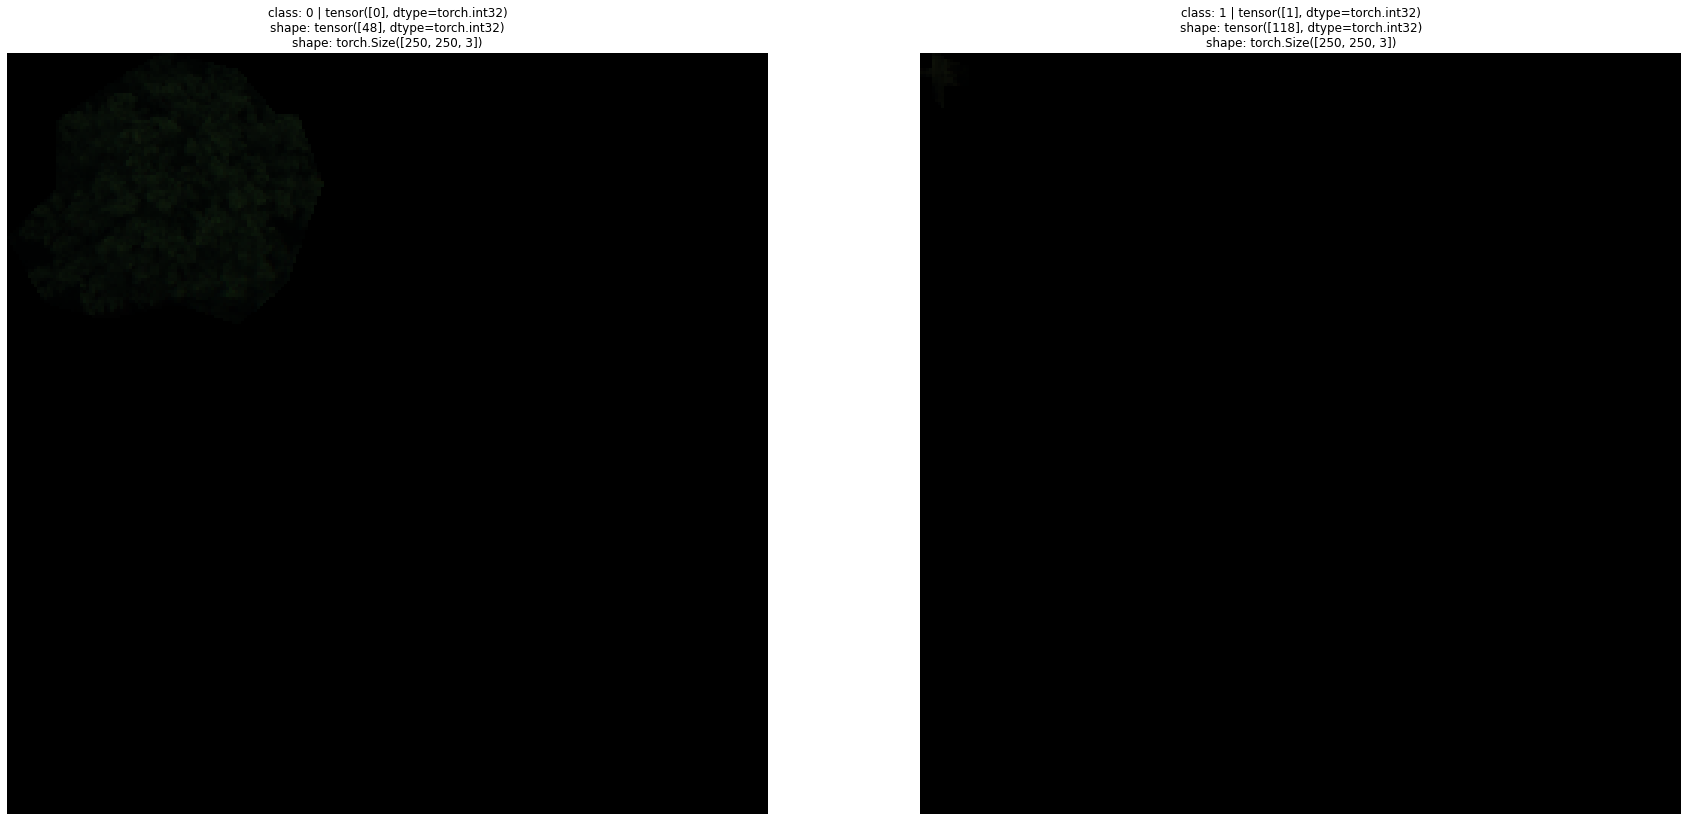

In [90]:
display_random_images(test_dataset, 
                      n=2, 
                      classes=[0, 1, 2, 3, 4],
                      seed=None)

In [57]:
import findatree_roi.exporter as exporter
import findatree_roi.io as io

old_hdf5 = r""
test_data_path = r""

data, params_data = io.load_hdf5(r'D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\2020\hdf5\tnr6969.hdf5')
channels, params_channels = data['channels'], params_data['channels']
crowns_human, params_crowns_human = data['crowns_human'], params_data['crowns_human']

params_export = {
    'channels_export': ['red','green','blue'],
    #'channels_export': ['blue','green','red','re','nir','chm'],
    'query_export': 'id > -1',
    'size_export': 300,
    }


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\2020\hdf5\tnr6969.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [10]:
rois, params_rois = exporter.export_rois(
    channels=channels,
    params_channels=params_channels,
    crowns=crowns_human,
    params_crowns=params_crowns_human,
    params_export=params_export,
    )


#exporter.rois_to_hdf5_v2(rois, params_rois, crowns, params_crowns, dir_name=r"")

#data_list = os.listdir(test_labels_path)
#data, params_data = io.load_hdf5(test_labels_path + "\\" + data_list[0])

NameError: name 'transformations' is not defined

In [63]:
params_data

{'channels': {'affine': array([[ 2.000000e-01,  0.000000e+00,  5.959600e+05],
         [ 0.000000e+00, -2.000000e-01,  5.244788e+06],
         [ 0.000000e+00,  0.000000e+00,  1.000000e+00]]),
  'crs': 'EPSG:25832',
  'date_time': '230302-144013',
  'downscale': 0,
  'max_ratio_blue': 0.0,
  'max_ratio_green': 0.0,
  'max_ratio_nir': 0.0,
  'max_ratio_re': 0.0,
  'max_ratio_red': 0.0,
  'path_dsm': 'D:\\Drohnendaten\\10_WZE-UAV\\Auswertung_findatree\\2020\\WZE-UAV-2020_DSM\\Tnr_11_D-20200909_DSM_highRMSE.tif',
  'path_dtm': 'D:\\Drohnendaten\\10_WZE-UAV\\Auswertung_findatree\\2020\\DTM_v2\\Tnr_11_D20200909_DTM.tif',
  'path_ortho': 'D:\\Drohnendaten\\10_WZE-UAV\\Auswertung_findatree\\2020\\WZE-UAV-2020_Ortho\\Tnr_11_D-20200909_Ortho_highRMSE.tif',
  'path_shapes': 'D:\\Drohnendaten\\10_WZE-UAV\\Auswertung_findatree\\2020\\Kronen\\Tnr_11_Kr.shp',
  'px_width': 0.2,
  'px_width_reproject': 0.2,
  'shape': array([1624, 1617]),
  'tnr': '11'},
 'crowns_human': {'affine': array([[ 2.000000e-

In [17]:
dataloader = DataLoader(test_dataset, batch_size=32)

In [36]:
image, label = dataset[0][0], dataset[0][1]
print(image.shape)
print(label.shape)
print(dataset.data.shape)
print(dataset.labels.shape)
print(len(dataset))
print(len(dataloader))
#print(image)
#print (label)

torch.Size([3, 300, 300])
torch.Size([1])
(5427, 300, 300, 3)
torch.Size([5427, 1])
5427
170


170